# Metody Obliczeniowe w Nauce i Technice
## Laboratorium 8 - Page Rank
### Albert Gierlach

Użyta wersja pythona:
* Python 3.8.3 64bit

Użyte biblioteki:
* networkx 2.4
* numpy 1.18.2
* matplotlib 3.2.1

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; 
}

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import random
import matplotlib as mtplt

np.set_printoptions(precision=3)
mtplt.rcParams['figure.figsize'] = [18, 9] # plots size

#### 1. Prosty ranking wierzchołków
Po zapoznaniu się z literaturą przystąpiłem do implementacji. Na początku zaimplementowałem funkcję generującą silnie spójny graf (taki, który będzie posiadał tylko jedną składową spójną). Grafy są tworzone za pomocą biblioteki networkx, która umożliwia pobranie macierzy adiacencji grafu. Każdy wiersz tej macierzy dzielę przez sumę wartości w tym wierszu (czyli de facto liczbe liczbę jedynek). Do weryfikacji obliczeń użyłem dwóch innych metod. Pierwsza z nich to podnoszenie znormalizowanej macierzy sąsiedztwa do potęgi, co odpowiada prawdopodobieństwom znalezienia się w danym stanie (czyli wierzchołku grafu lub stronie internetowej). Druga metoda to metoda statystyczna - dla każdego wierzchołka mierzę ile razy algorytm błądzenia po grafie zakończy się w nim. Każdy wektor wynikowy będzie miarą prawdopodobieństwa, mówiącą o tym jak prawdopodobne będzie znalezienie się w danym wierzchołku. Każdy z tych wektorów będzie sumować się do jedynki.

In [3]:
# generate graph unitl there is one strongly connected component
def gen_graph(n, prob=0.5):
    while True:
        G = nx.binomial_graph(n, prob, None, True)
        if nx.number_strongly_connected_components(G) == 1:
            break

    return G


def draw_graph(G, layout, title=""):
    plt.figure(title)
    nx.draw_networkx_nodes(G, layout, node_color='blue', node_size=400)

    nx.draw_networkx_edges(G, layout, connectionstyle='arc3, rad = 0.2', width=1.3, alpha=0.5)
    nx.draw_networkx_labels(G, layout, font_size=10, font_color="white", font_weight='bold')

    plt.axis('off')
    plt.title(title)
    plt.draw()

Każda metoda została wydzielona do osobnej klasy, w celu lepszej czytelności kodu. Pierwsza z nich opierająca się na wektorach własnych. Wykorzystałem metodę potęgową z poprzednich laboratoriów.

In [4]:
class EigenVectorMethod:
    def __init__(self, A, max_iterations=10 ** 4, epsilon=1e-6):
        self.A = A.T
        self.n = A.shape[0]
        self.max_iterations = max_iterations
        self.eps = epsilon

    def compute(self):
        eigen_vector = self.power_method()
        eigen_vector /= sum(eigen_vector) # normalize
        return eigen_vector

    def power_method(self):
        x_ = np.random.random(self.n)
        x_ /= np.linalg.norm(x_)
        for _ in range(self.max_iterations):
            x_i = self.A @ x_
            x_i /= np.linalg.norm(x_i)  # vec normalization
            if np.linalg.norm(x_i - x_) < self.eps:
                break
            x_ = x_i

        return x_.T

Kolejną metodą jest metoda podnoszenia znormalizowanej macierzy adiacencji do potęgi. Dzięki temu otrzymamy macierz mówiącą o prawdopodobieństwach znalezienia się w danym wierzchołku po N iteracjach. Jako iż dostajemy macierz musimy wybrać jeden z wierszy.

In [5]:
class MatrixPowerMethod:
    def __init__(self, A):
        self.A = A
        self.n = A.shape[0]

    def compute(self, exponent=50, start_vec=None):
        if not start_vec:
            start_vec = np.zeros(self.n)
            start_vec[random.randrange(self.n)] = 1

        powered_matrix = np.linalg.matrix_power(self.A, exponent)
        result_vec = powered_matrix.T @ start_vec
        return result_vec

Ostatnią metodą jest metoda statystyczna, która jest dość prosta w swoim działaniu. Powtarzamy algorytm błądzenia po grafie N razy, każdorazowo odwiedzając M wierzchołków. Na koniec sprawdzamy, w którym wierzchołku zakończyliśmy i zapisujemy tą informację. Ostatecznie otrzymujemy listę, która zawiera informacje ile razy zakończyliśmy wędrówkę w danym wierzchołku. Wystarczy potraktować ją jako wektor oraz znormalizować i otrzymamy prawdopodobieństwa znalezienia się w odpowiednich wierzchołkach.

In [6]:
class StatisticMethod:
    def __init__(self, A):
        self.A = A
        self.n = A.shape[0]

    def compute(self, single_run_len=150, total_runs=2000):
        statistics = np.zeros(self.n)
        for _ in range(total_runs):
            last_page = self.last_page(random.randrange(self.n), single_run_len)
            statistics[last_page] += 1

        statistics /= sum(statistics)
        return statistics

    def last_page(self, start_page, single_run_len):
        last_page_in_run = start_page
        for _ in range(single_run_len):
            last_page_in_run = self.next_page(self.A[last_page_in_run])

        return last_page_in_run

    def next_page(self, row_of_pobabilities):
        return np.random.choice(
            [i for i in range(self.n)],
            p=row_of_pobabilities
        )

Mając powyższe metody zaimplementowałem zbiorczą metodę, która wywołuje wszystkie trzy sposoby i wyświetla wyniki.

In [7]:
def random_surfer(G):
    print("Graph with {} nodes".format(G.number_of_nodes()))
    draw_graph(G, nx.spring_layout(G))
    plt.show()

    adj_matrix = nx.to_numpy_array(G)
    normalized_adj_matrix = adj_matrix / adj_matrix.sum(axis=1)[:, None]  # normalize

    eigen_vector_result = EigenVectorMethod(normalized_adj_matrix).compute()
    matrix_power_method_result = MatrixPowerMethod(normalized_adj_matrix).compute()
    statistical_result = StatisticMethod(normalized_adj_matrix).compute()
    
    fmt = "|{:^.4f}|{:^.4f}|{:^.4f}|"
    print("|{:^6}|{:^6}|{:^6}|".format("EIGEN", "MAT", "STAT"))
    print('-' * 22)
    for i in range(len(eigen_vector_result)):
        print(fmt.format(eigen_vector_result[i], matrix_power_method_result[i], statistical_result[i]))

Najpierw przetestowałem manualnie stworzony graf. Później użyłem funkcji generującej losowe grafy.

Graph with 4 nodes


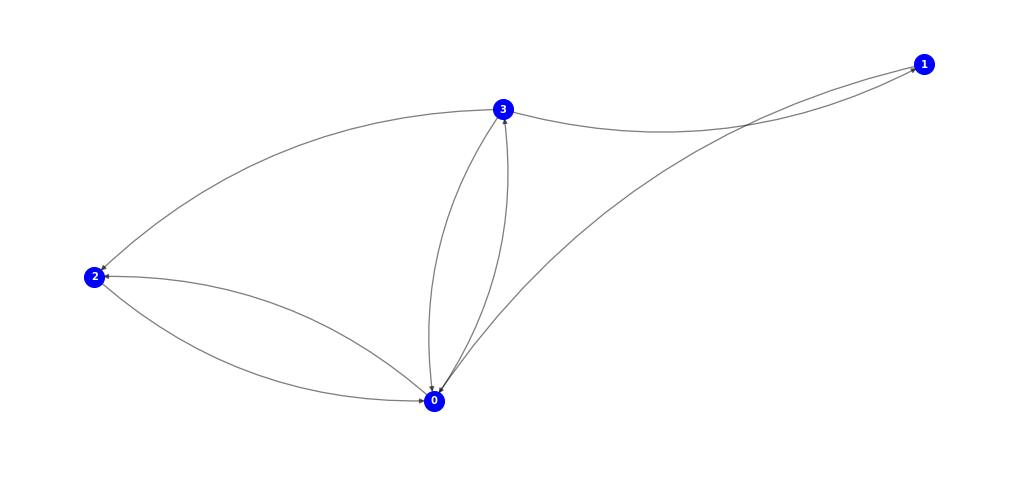

|EIGEN | MAT  | STAT |
----------------------
|0.4286|0.4286|0.4305|
|0.0714|0.0714|0.0755|
|0.2857|0.2857|0.2825|
|0.2143|0.2143|0.2115|


In [8]:
arr = np.array([[0, 0, 1, 1],
                [1, 0, 0, 0],
                [1, 0, 0, 0],
                [1, 1, 1, 0]])

G = nx.from_numpy_array(arr, create_using=nx.DiGraph)
random_surfer(G)

Graph with 15 nodes


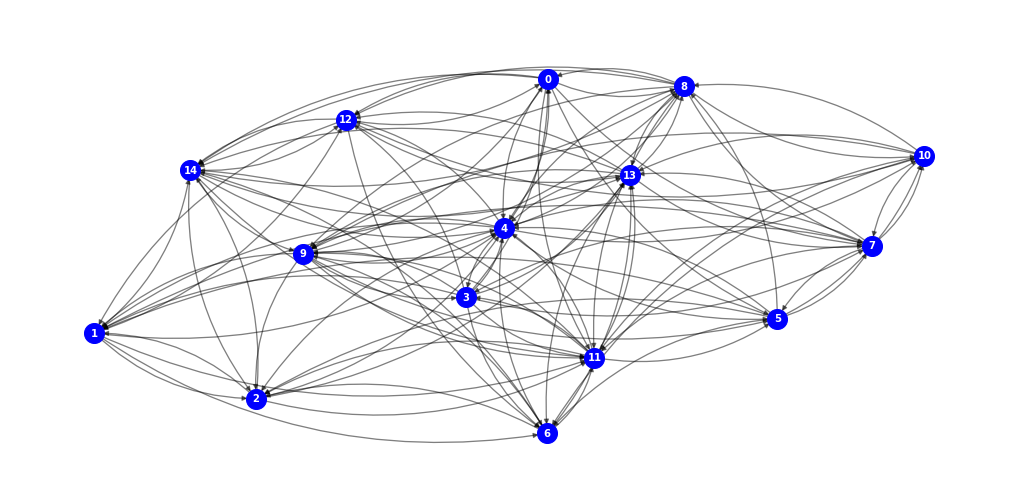

|EIGEN | MAT  | STAT |
----------------------
|0.0429|0.0429|0.0400|
|0.0637|0.0637|0.0595|
|0.0759|0.0759|0.0810|
|0.0399|0.0399|0.0380|
|0.1049|0.1049|0.1060|
|0.0460|0.0460|0.0445|
|0.0624|0.0624|0.0580|
|0.0440|0.0440|0.0460|
|0.0654|0.0654|0.0655|
|0.0800|0.0800|0.0875|
|0.0413|0.0413|0.0455|
|0.0919|0.0919|0.0880|
|0.0643|0.0643|0.0605|
|0.0890|0.0890|0.0790|
|0.0882|0.0882|0.1010|


In [9]:
random_surfer(gen_graph(15, 0.5))

Graph with 25 nodes


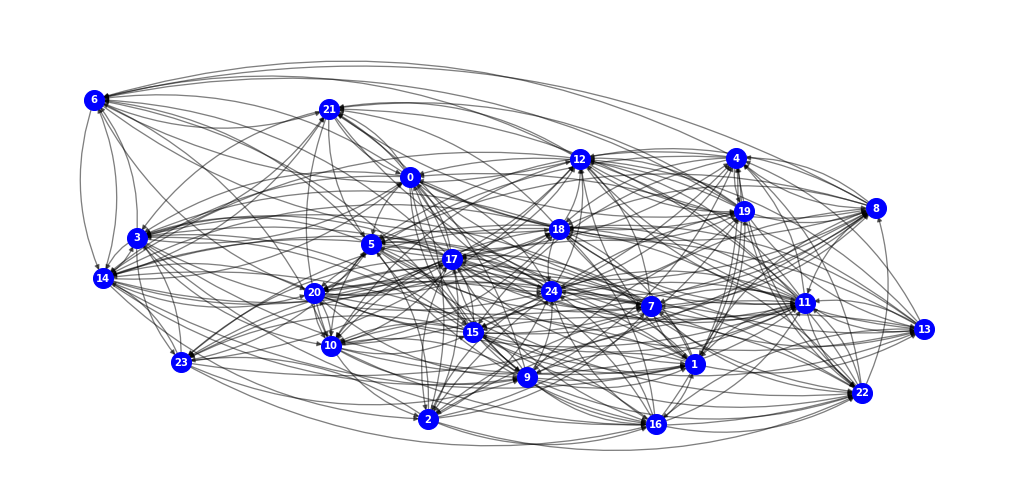

|EIGEN | MAT  | STAT |
----------------------
|0.0340|0.0340|0.0310|
|0.0398|0.0398|0.0340|
|0.0272|0.0272|0.0225|
|0.0436|0.0436|0.0405|
|0.0424|0.0424|0.0445|
|0.0432|0.0432|0.0520|
|0.0471|0.0471|0.0495|
|0.0386|0.0386|0.0350|
|0.0419|0.0419|0.0350|
|0.0303|0.0303|0.0295|
|0.0444|0.0444|0.0440|
|0.0550|0.0550|0.0610|
|0.0544|0.0544|0.0510|
|0.0351|0.0351|0.0385|
|0.0455|0.0455|0.0480|
|0.0290|0.0290|0.0310|
|0.0305|0.0305|0.0270|
|0.0323|0.0323|0.0330|
|0.0600|0.0600|0.0650|
|0.0371|0.0371|0.0355|
|0.0391|0.0391|0.0395|
|0.0474|0.0474|0.0510|
|0.0447|0.0447|0.0455|
|0.0236|0.0236|0.0265|
|0.0336|0.0336|0.0300|


In [10]:
random_surfer(gen_graph(25, 0.4))

Graph with 40 nodes


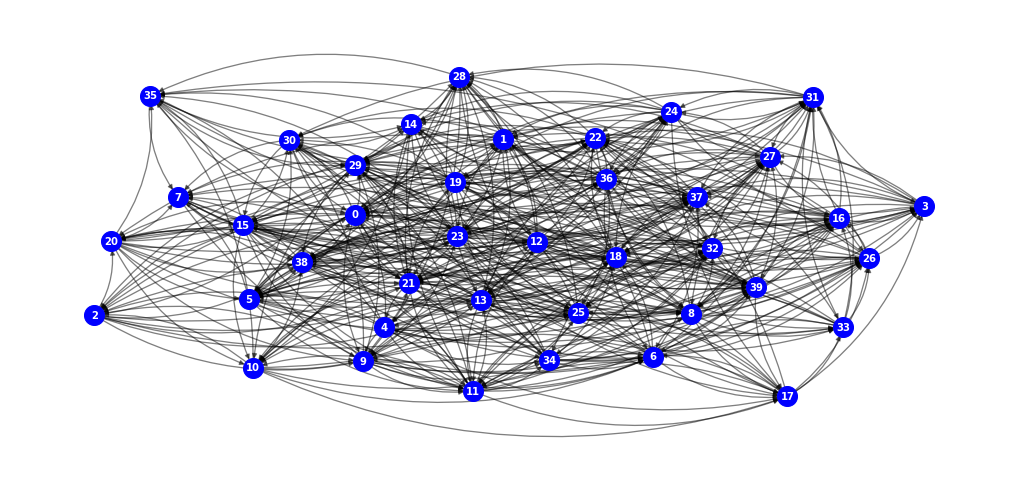

|EIGEN | MAT  | STAT |
----------------------
|0.0281|0.0281|0.0335|
|0.0230|0.0230|0.0235|
|0.0165|0.0165|0.0140|
|0.0259|0.0259|0.0315|
|0.0109|0.0109|0.0090|
|0.0326|0.0326|0.0300|
|0.0221|0.0221|0.0245|
|0.0183|0.0183|0.0185|
|0.0237|0.0237|0.0260|
|0.0215|0.0215|0.0240|
|0.0203|0.0203|0.0205|
|0.0294|0.0294|0.0270|
|0.0110|0.0110|0.0165|
|0.0291|0.0291|0.0265|
|0.0167|0.0167|0.0180|
|0.0171|0.0171|0.0150|
|0.0290|0.0290|0.0275|
|0.0175|0.0175|0.0120|
|0.0320|0.0320|0.0320|
|0.0152|0.0152|0.0120|
|0.0176|0.0176|0.0160|
|0.0341|0.0341|0.0360|
|0.0367|0.0367|0.0345|
|0.0285|0.0285|0.0365|
|0.0211|0.0211|0.0195|
|0.0332|0.0332|0.0335|
|0.0279|0.0279|0.0210|
|0.0362|0.0362|0.0430|
|0.0292|0.0292|0.0275|
|0.0337|0.0337|0.0300|
|0.0198|0.0198|0.0185|
|0.0297|0.0297|0.0325|
|0.0319|0.0319|0.0295|
|0.0149|0.0149|0.0135|
|0.0139|0.0139|0.0150|
|0.0182|0.0182|0.0175|
|0.0204|0.0204|0.0215|
|0.0432|0.0432|0.0380|
|0.0358|0.0358|0.0425|
|0.0341|0.0341|0.0325|


In [11]:
random_surfer(gen_graph(40, 0.3))

Jak widać obliczenia w dużej mierze zgadzają się z zebraną statystyką. Ranking wierzchołków pokazuje nam jakie są szanse przejścia, że przypadkowy użytkownik przejdzie na daną stronę. Ten model nie uwzględnia możliwości przejścia bezpośredniego (tzw. teleport) na naszą stronę. Model Page Rank zakłada taką możliwość.

#### 2. Page Rank

Page Rank to właściwie rozszerzenie modelu błądzenia. Page Rank uwzględnia możliwość tzw. teleportacji, czyli możliwości, że użytkownik z danej strony przeskoczy na inną nie używając linku (np. wpisując bezpośredni adres w pasek adresu). Metoda jest podobna do rankingu wierzchołków, ale przydzielamy wagę (współczynnik d) dla macierzy incydencji oraz dla macierzy przypadkowych przejść. Do implementacji wykorzystałem podany w treści zadania pseudokod oraz podane równanie macierzowe.

Na początku stworzyłem dwie funckje służące do generowania wektora e. Jedna tworzy go losowa, a druga wypełnia go identycznymi wartościami sumującymi się do jedynki.

In [12]:
def e_random(n):
    return np.random.random_sample(n).reshape((n, 1))

def e_same_weight(n):
    return np.ones(n).reshape((n, 1))

Następnie przystąpiłem do implementacji właściwego algorytmu. Metoda potęgowa korzysta z pseudokodu zawartego w instrukcji.

In [13]:
def page_rank(A, d, e_func=e_random, eps=1e-6):
    n = A.shape[0]

    e_vec = e_func(n)
    e_vec /= np.linalg.norm(e_vec, ord=1)
    B = np.array(d * A.T + ((1-d) * (e_vec @ np.ones(shape=(1, n)))), dtype=float)

    r = e_vec.copy()
    delta = 1
    while delta > eps:
        r_next = B @ r
        d_ = np.linalg.norm(r, ord=1) - np.linalg.norm(r_next, ord=1)
        r_next += (d_ * e_vec)
        delta = np.linalg.norm(r_next - r, ord=1)
        r = r_next

    r = np.array(r)
    print(r)
    print("Sum == 1? {}".format("Yes" if sum(r) else "No"))

Pobrałem trzy przykładowe grafy z nazy SNAP oraz napisałem funkcję wczytującą grafy.

In [14]:
def load_graph(filename):
    G = nx.DiGraph()
    with open(filename, "r") as f:
        lines = f.read().splitlines()
        for line in lines:
            if line[0] != '#':
                a, b = line.split()
                G.add_edge(a, b)

    G = nx.convert_node_labels_to_integers(G, first_label=0)
    return nx.to_numpy_array(G)

Kod testujący dla 3 różnych grafów, 5 różnych wartości d oraz dwóch różnych strategii generowania wektora e przedstawiam poniżej.

In [15]:
data_format = "./data/{}"

files = ["p2p-Gnutella09.txt", "Wiki-Vote.txt", "email-Eu-core.txt"]
ds = [0.9, 0.85, 0.75, 0.6, 0.5]
for f in files:
    A = load_graph(data_format.format(f))

    for i, row in enumerate(A):  # normalize only once
        s = sum(row)
        if s:
            A[i] = row / s

    for d in ds:
        for e in [e_random, e_same_weight]:
            print("Graph: {} ({} nodes), d={}, e={}".format(f, A.shape[0], d, e.__name__))

            page_rank(A, d, e)
            print("\n")

Graph: p2p-Gnutella09.txt (8114 nodes), d=0.9, e=e_random
[[1.207e-04]
 [1.725e-04]
 [1.725e-04]
 ...
 [5.012e-05]
 [9.467e-05]
 [1.238e-04]]
Sum == 1? Yes


Graph: p2p-Gnutella09.txt (8114 nodes), d=0.9, e=e_same_weight
[[8.508e-05]
 [1.709e-04]
 [1.541e-04]
 ...
 [8.602e-05]
 [8.578e-05]
 [9.411e-05]]
Sum == 1? Yes


Graph: p2p-Gnutella09.txt (8114 nodes), d=0.85, e=e_random
[[3.976e-05]
 [2.112e-04]
 [1.200e-04]
 ...
 [4.552e-05]
 [1.775e-05]
 [7.637e-05]]
Sum == 1? Yes


Graph: p2p-Gnutella09.txt (8114 nodes), d=0.85, e=e_same_weight
[[8.764e-05]
 [1.692e-04]
 [1.530e-04]
 ...
 [8.849e-05]
 [8.828e-05]
 [9.630e-05]]
Sum == 1? Yes


Graph: p2p-Gnutella09.txt (8114 nodes), d=0.75, e=e_random
[[6.653e-05]
 [9.076e-05]
 [2.100e-04]
 ...
 [1.524e-04]
 [1.547e-04]
 [4.962e-05]]
Sum == 1? Yes


Graph: p2p-Gnutella09.txt (8114 nodes), d=0.75, e=e_same_weight
[[9.258e-05]
 [1.654e-04]
 [1.506e-04]
 ...
 [9.326e-05]
 [9.311e-05]
 [1.004e-04]]
Sum == 1? Yes


Graph: p2p-Gnutella09.txt (8114 n

Jak widać wyniki zwrócone przez page rank są poprawne, chociaż niektóre wartości są tak małe, że wyświetlają się jakby były równe zero.

### Wnioski
* Page Rank mówi o tym jak prawdopodobne jest znalezienie się na danej stronie po wielu przejściach między stronami.
* Page Rank może być użyty do oszacowania jak duży ruch sieciowy będzie na danej stronie.
* Dla bardzo dużych grafów może być konieczne rozważenie algorytmu w postaci rozproszonej. Algorytm tworzy wielkie macierze, które muszą być przechowywane w pamięci. Mnożenie takich macierzy także jest kosztowne czasowo. Rozproszenie obliczeń może rozwiązać taki problem.
* Problem składowania dużych macierzy można rozwiązać poprzez kompresję, niestety jest to kolejny narzut obliczeniowy.
* W praktyce stosuje się dużo bardziej złożone algorytmy, które biorą pod uwagę wiele innych czynników.
* Współczynnikiem 'd' można sterować wpływ jaki mają teleportacje (bezpośrednie przejścia) między stronami. W praktyce najczęściej stosuje się d=0.85